In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings as wr
wr.filterwarnings(action="ignore")
import seaborn as sns

In [102]:
from pyspark.sql import SparkSession

# Crear la sesión de Spark
spark = SparkSession.builder \
    .appName("Fraud Detection") \
    .getOrCreate()

<div style="background-color: #3498db; border-radius: 10px; text-align: center; padding: 10px;">
    <h1>Carga del dataset</h1>
</div>


We are merging multiple datasets 

In [103]:
# Cargar el dataset
account = spark.read.csv("Data/Customer Profiles/account_activity.csv", header=True, inferSchema=True)
customer = spark.read.csv("Data/Customer Profiles/customer_data.csv", header=True, inferSchema=True)
fraud = spark.read.csv("Data/Fraudulent Patterns/fraud_indicators.csv", header=True, inferSchema=True)
suspision = spark.read.csv("Data/Fraudulent Patterns/suspicious_activity.csv", header=True, inferSchema=True)
merchant = spark.read.csv("Data/Merchant Information/merchant_data.csv", header=True, inferSchema=True)
tran_cat = spark.read.csv("Data/Merchant Information/transaction_category_labels.csv", header=True, inferSchema=True)
amount = spark.read.csv("Data/Transaction Amounts/amount_data.csv", header=True, inferSchema=True)
anamoly = spark.read.csv("Data/Transaction Amounts/anomaly_scores.csv", header=True, inferSchema=True)
tran_data = spark.read.csv("Data/Transaction Data/transaction_metadata.csv", header=True, inferSchema=True)
tran_rec = spark.read.csv("Data/Transaction Data/transaction_records.csv", header=True, inferSchema=True)

In [104]:
data = [account,customer,fraud,suspision,merchant,tran_cat,amount,anamoly,tran_data,tran_rec]

In [105]:
for df in data:
    print(df.show(5))

+----------+------------------+----------+
|CustomerID|    AccountBalance| LastLogin|
+----------+------------------+----------+
|      1001|  9507.27205955636|2022-01-01|
|      1002| 7408.704535557173|2022-01-02|
|      1003| 1715.321988918382|2022-01-03|
|      1004|3101.5091338402535|2022-01-04|
|      1005| 5405.766913696731|2022-01-05|
+----------+------------------+----------+
only showing top 5 rows

None
+----------+-------------+---+------------+
|CustomerID|         Name|Age|     Address|
+----------+-------------+---+------------+
|      1001|Customer 1001| 54|Address 1001|
|      1002|Customer 1002| 35|Address 1002|
|      1003|Customer 1003| 40|Address 1003|
|      1004|Customer 1004| 30|Address 1004|
|      1005|Customer 1005| 46|Address 1005|
+----------+-------------+---+------------+
only showing top 5 rows

None
+-------------+--------------+
|TransactionID|FraudIndicator|
+-------------+--------------+
|            1|             0|
|            2|             0|
| 

In [106]:
customer_data = customer.join(account, "CustomerID", "inner")
customer_data = customer_data.join(suspision, "CustomerID", "inner")

customer_data.show()

+----------+-------------+---+------------+------------------+----------+--------------+
|CustomerID|         Name|Age|     Address|    AccountBalance| LastLogin|SuspiciousFlag|
+----------+-------------+---+------------+------------------+----------+--------------+
|      1001|Customer 1001| 54|Address 1001|  9507.27205955636|2022-01-01|             0|
|      1002|Customer 1002| 35|Address 1002| 7408.704535557173|2022-01-02|             0|
|      1003|Customer 1003| 40|Address 1003| 1715.321988918382|2022-01-03|             0|
|      1004|Customer 1004| 30|Address 1004|3101.5091338402535|2022-01-04|             0|
|      1005|Customer 1005| 46|Address 1005| 5405.766913696731|2022-01-05|             0|
|      1006|Customer 1006| 59|Address 1006| 9347.967162033714|2022-01-06|             0|
|      1007|Customer 1007| 33|Address 1007|2957.7600542968958|2022-01-07|             0|
|      1008|Customer 1008| 21|Address 1008| 8303.773585052018|2022-01-08|             0|
|      1009|Customer 

In [107]:
transaction_data1 = fraud.join(tran_cat, "TransactionID", "inner")
transaction_data2 = amount.join(anamoly, "TransactionID", "inner")
transaction_data3 = tran_data.join(tran_rec, "TransactionID", "inner")
transaction_data = transaction_data1 \
    .join(transaction_data2, "TransactionID", "inner") \
    .join(transaction_data3, "TransactionID", "inner")


In [108]:
transaction_data.show()


+-------------+--------------+--------+------------------+--------------------+-------------------+----------+------------------+----------+
|TransactionID|FraudIndicator|Category| TransactionAmount|        AnomalyScore|          Timestamp|MerchantID|            Amount|CustomerID|
+-------------+--------------+--------+------------------+--------------------+-------------------+----------+------------------+----------+
|          148|             0|  Online| 78.51656294055846|  0.5996910725465628|2022-01-07 03:00:00|      2369| 79.52197137501955|      1066|
|          463|             0|    Food| 71.39490628695674|  0.2480703985398326|2022-01-20 06:00:00|      2984| 44.86059945676822|      1623|
|          471|             0|  Travel|49.038845671723635|  0.1589909742837219|2022-01-20 14:00:00|      2629| 57.86820257846373|      1696|
|          496|             0|  Travel| 72.22326538432765|  0.8041714286503358|2022-01-21 15:00:00|      2164|   38.411192485188|      1126|
|          83

In [109]:
data = transaction_data.join(customer_data, "CustomerID", "inner")
data.show()

+----------+-------------+--------------+--------+------------------+-------------------+-------------------+----------+------------------+-------------+---+------------+------------------+----------+--------------+
|CustomerID|TransactionID|FraudIndicator|Category| TransactionAmount|       AnomalyScore|          Timestamp|MerchantID|            Amount|         Name|Age|     Address|    AccountBalance| LastLogin|SuspiciousFlag|
+----------+-------------+--------------+--------+------------------+-------------------+-------------------+----------+------------------+-------------+---+------------+------------------+----------+--------------+
|      1591|          183|             0|  Online|13.294878186725366| 0.9666454635140961|2022-01-08 14:00:00|      2671| 71.65549550773102|Customer 1591| 36|Address 1591|  7962.41027548533|2023-08-14|             0|
|      1591|          539|             0|    Food| 80.17991437866195|0.18223681843836848|2022-01-23 10:00:00|      2830| 59.586955573877

<div style="background-color: #bde0fe; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: black;">Data Exploration</h1>
</div>


In [110]:
data.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- TransactionID: integer (nullable = true)
 |-- FraudIndicator: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- TransactionAmount: double (nullable = true)
 |-- AnomalyScore: double (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- MerchantID: integer (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Address: string (nullable = true)
 |-- AccountBalance: double (nullable = true)
 |-- LastLogin: date (nullable = true)
 |-- SuspiciousFlag: integer (nullable = true)



In [111]:
# Número de filas y columnas
num_rows = data.count()
num_columns = len(data.columns)
print(f"Shape: ({num_rows}, {num_columns})")

Shape: (1000, 15)


In [112]:
data.describe().show()

+-------+-----------------+-----------------+------------------+--------+------------------+--------------------+------------------+------------------+-------------+------------------+------------+-----------------+-------------------+
|summary|       CustomerID|    TransactionID|    FraudIndicator|Category| TransactionAmount|        AnomalyScore|        MerchantID|            Amount|         Name|               Age|     Address|   AccountBalance|     SuspiciousFlag|
+-------+-----------------+-----------------+------------------+--------+------------------+--------------------+------------------+------------------+-------------+------------------+------------+-----------------+-------------------+
|  count|             1000|             1000|              1000|    1000|              1000|                1000|              1000|              1000|         1000|              1000|        1000|             1000|               1000|
|   mean|         1496.626|            500.5|           

In [113]:
columns = data.columns
print(columns)

['CustomerID', 'TransactionID', 'FraudIndicator', 'Category', 'TransactionAmount', 'AnomalyScore', 'Timestamp', 'MerchantID', 'Amount', 'Name', 'Age', 'Address', 'AccountBalance', 'LastLogin', 'SuspiciousFlag']


In [114]:
# Identificar columnas numéricas y categóricas
numerical_features = [col for col, dtype in data.dtypes if dtype in ('int', 'double')]
categorical_features = [col for col, dtype in data.dtypes if dtype in ('string', 'timestamp', 'date')]	
print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['CustomerID', 'TransactionID', 'FraudIndicator', 'TransactionAmount', 'AnomalyScore', 'MerchantID', 'Amount', 'Age', 'AccountBalance', 'SuspiciousFlag']
Categorical features: ['Category', 'Timestamp', 'Name', 'Address', 'LastLogin']


<div style="background-color: #cdb4db; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: black;">Data Visualization</h1>
</div>


In [115]:
data_df = data.toPandas()

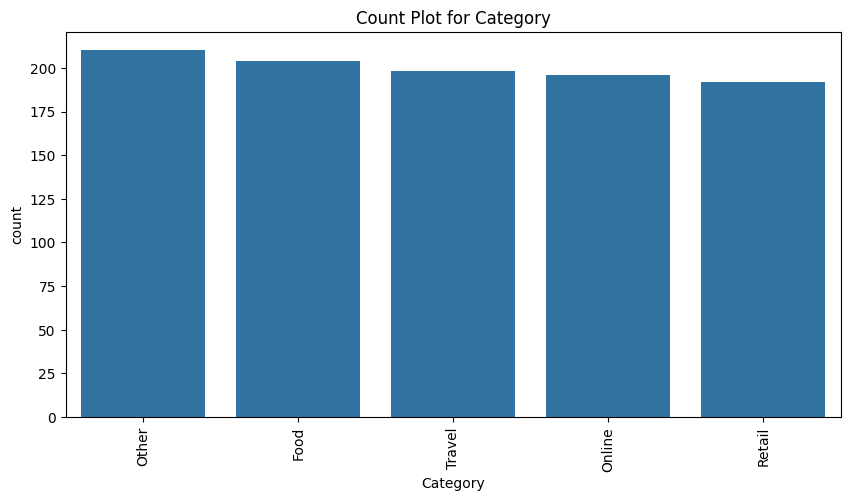

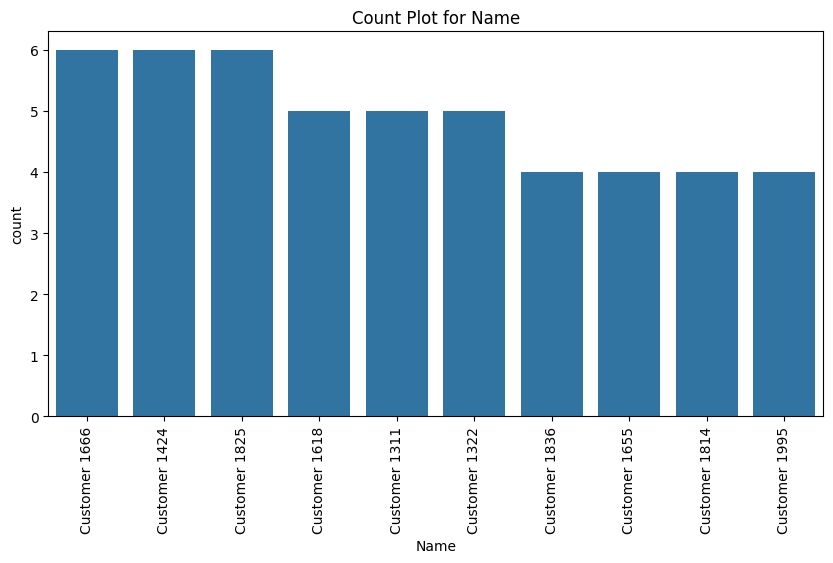

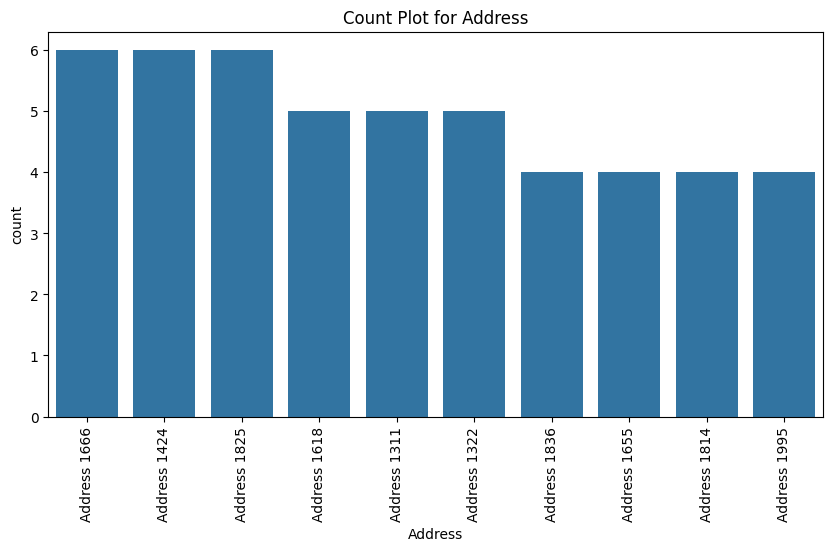

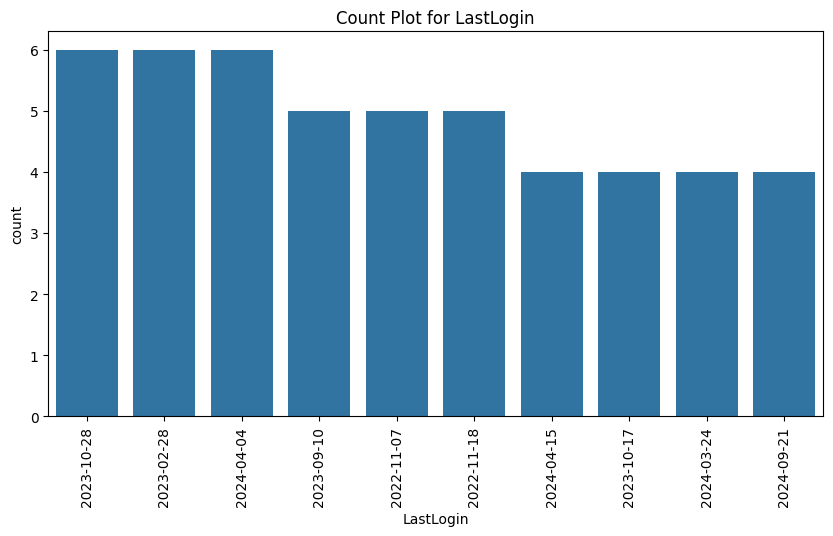

In [116]:
for column in data_df.columns:
    if data_df[column].dtype == 'object':  # Check if the column has a categorical data type
        top_10_values = data_df[column].value_counts().head(10)  # Get the first 10 unique values and their counts
        plt.figure(figsize=(10, 5))  # Adjust the figure size if needed
        sns.countplot(x=column, data=data_df, order=top_10_values.index)
        plt.title(f'Count Plot for {column}')
        plt.xticks(rotation=90)  # Rotate x-axis labels if they are long
        plt.show()



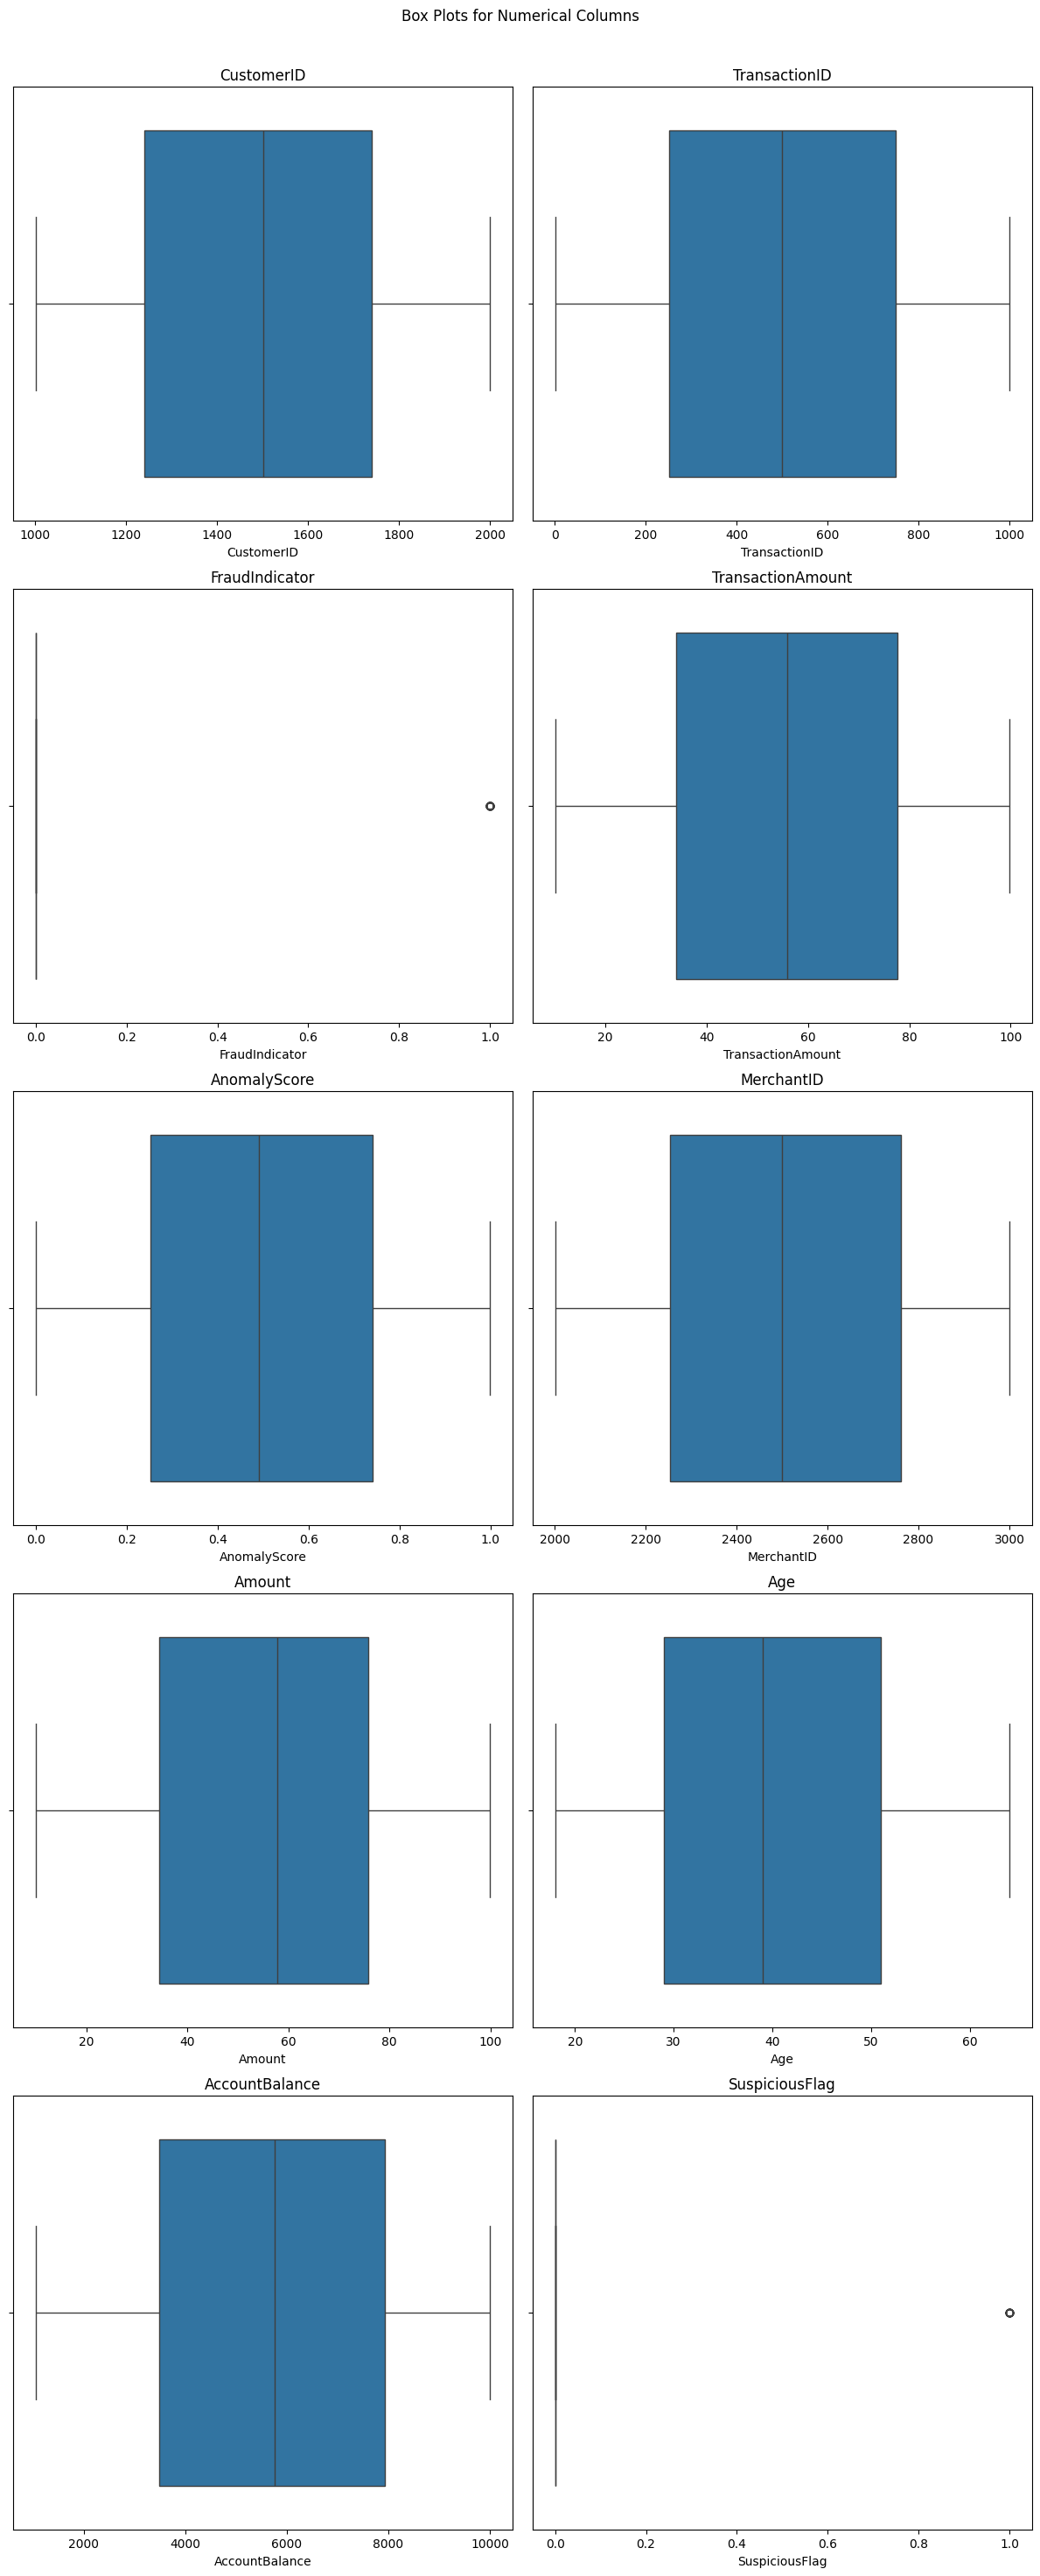

In [117]:
# Assuming 'data' is your DataFrame containing numerical columns

# Get the number of numerical columns
num_cols = len(data_df.select_dtypes(include=['number']).columns)

# Calculate the number of rows and columns for subplots
num_rows = (num_cols // 2) + (num_cols % 2)

# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6*num_rows))
fig.suptitle("Box Plots for Numerical Columns")

# Loop through the numerical columns and create box plots
for i, column in enumerate(data_df.select_dtypes(include=['number']).columns):
    row = i // 2
    col = i % 2
    sns.boxplot(x=data_df[column], ax=axes[row, col])
    axes[row, col].set_title(column)

# Remove any empty subplots
if num_cols % 2 != 0:
    fig.delaxes(axes[num_rows-1, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the position of the overall title
plt.show()


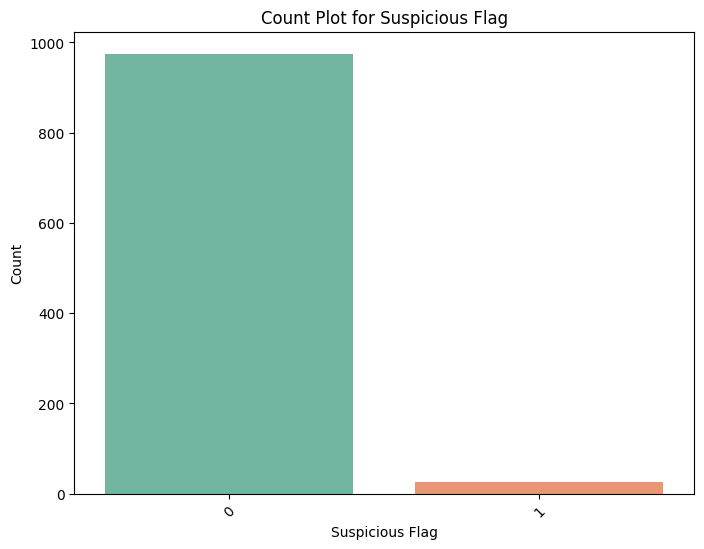

In [118]:
# We should use countplot for SuspiciousFlag feature

plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.countplot(x='SuspiciousFlag', data=data_df, palette='Set2')  # You can change the palette as desired
plt.title('Count Plot for Suspicious Flag')
plt.xlabel('Suspicious Flag')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if they are long

plt.show()

Okay we can see the dataset's target feature is heavily imbalanced sowe can use further techiniqes to equalize the feature's values 

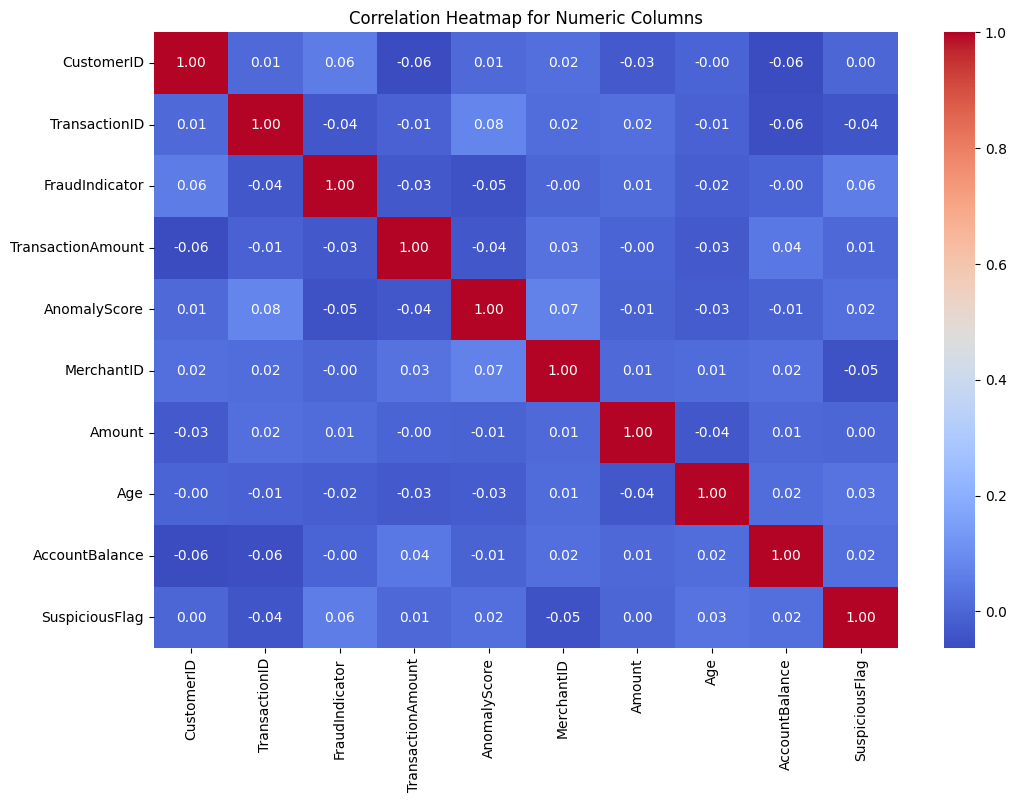

In [119]:

# Select only the numeric columns
numeric_data = data_df.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_data.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Numeric Columns')

plt.show()


<div style="background-color: #ffc8dd; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: black;">Feature Engineering</h1>
</div>


In [120]:
# Dropping the columns as of now they are not mush corelated & also wouldn't damper the performance of model
columns_to_be_dropped = ['TransactionID','MerchantID','CustomerID','Name', 'Age', 'Address']

In [121]:
data1 = data.drop(*columns_to_be_dropped) 
data1.show(5)

+--------------+--------+------------------+------------------+-------------------+-----------------+------------------+----------+--------------+
|FraudIndicator|Category| TransactionAmount|      AnomalyScore|          Timestamp|           Amount|    AccountBalance| LastLogin|SuspiciousFlag|
+--------------+--------+------------------+------------------+-------------------+-----------------+------------------+----------+--------------+
|             0|  Online| 78.51656294055846|0.5996910725465628|2022-01-07 03:00:00|79.52197137501955| 8979.728844071804|2022-03-07|             0|
|             0|    Food| 71.39490628695674|0.2480703985398326|2022-01-20 06:00:00|44.86059945676822|2341.7106823841923|2023-09-15|             0|
|             0|  Travel|49.038845671723635|0.1589909742837219|2022-01-20 14:00:00|57.86820257846373| 6165.705182432255|2023-11-27|             0|
|             0|  Travel| 72.22326538432765|0.8041714286503358|2022-01-21 15:00:00|  38.411192485188| 7080.10343861993

In [122]:
fraud_counts = data1.groupBy("FraudIndicator").count()
suspicious_counts = data1.groupBy("SuspiciousFlag").count()
category_counts = data1.groupBy("Category").count()
fraud_counts.show()
suspicious_counts.show()
category_counts.show()

+--------------+-----+
|FraudIndicator|count|
+--------------+-----+
|             1|   45|
|             0|  955|
+--------------+-----+

+--------------+-----+
|SuspiciousFlag|count|
+--------------+-----+
|             1|   25|
|             0|  975|
+--------------+-----+

+--------+-----+
|Category|count|
+--------+-----+
|    Food|  204|
|  Travel|  198|
|   Other|  210|
|  Online|  196|
|  Retail|  192|
+--------+-----+



Consiste en: Seleccionar y transformar las variables que se utilizarán en el modelo, Normalizar variables, Manipular datos categóricos, Crear nuevas variables a partir de las existentes

In [123]:
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType
# Using Feature Engineering Creating two Columns
# Hour of Transaction = hour
# Gap between the day of transaction and last login in days = gap
if data1.schema['Timestamp'].dataType == TimestampType():
    print("The 'Timestamp' column is already in datetime format.")
else:
    print("The 'Timestamp' column is not in datetime format.")

The 'Timestamp' column is already in datetime format.


Converting TimeStamp to datetime format

In [124]:
data1 = data1.withColumn('Timestamp1', F.col('Timestamp').cast(TimestampType()))

data1.printSchema()

root
 |-- FraudIndicator: integer (nullable = true)
 |-- Category: string (nullable = true)
 |-- TransactionAmount: double (nullable = true)
 |-- AnomalyScore: double (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- Amount: double (nullable = true)
 |-- AccountBalance: double (nullable = true)
 |-- LastLogin: date (nullable = true)
 |-- SuspiciousFlag: integer (nullable = true)
 |-- Timestamp1: timestamp (nullable = true)



In [125]:
data1 = data1.withColumn('Hour', F.hour('Timestamp1'))
data1 = data1.withColumn('LastLogin', F.col('LastLogin').cast(TimestampType()))
data1 = data1.withColumn('gap', F.abs(F.datediff('Timestamp1', 'LastLogin')))

data1.show(5)

+--------------+--------+------------------+-------------------+-------------------+-----------------+-----------------+-------------------+--------------+-------------------+----+---+
|FraudIndicator|Category| TransactionAmount|       AnomalyScore|          Timestamp|           Amount|   AccountBalance|          LastLogin|SuspiciousFlag|         Timestamp1|Hour|gap|
+--------------+--------+------------------+-------------------+-------------------+-----------------+-----------------+-------------------+--------------+-------------------+----+---+
|             0|  Online|13.294878186725366| 0.9666454635140961|2022-01-08 14:00:00|71.65549550773102| 7962.41027548533|2023-08-14 00:00:00|             0|2022-01-08 14:00:00|  14|583|
|             0|    Food| 80.17991437866195|0.18223681843836848|2022-01-23 10:00:00|59.58695557387782| 7962.41027548533|2023-08-14 00:00:00|             0|2022-01-23 10:00:00|  10|568|
|             0|    Food|40.347012916706845|0.28108498718802843|2022-02-11 

<div style="background-color: #ccd5ae; border-radius: 10px; text-align: center; padding: 20px;">
    <h1 style="color: black;">Data Modelling</h1>
</div>


In [126]:
# Se eliminan las columnas que no son relevantes y se separa la variable objetivo en la variable Y
X = data1.drop(*['FraudIndicator', 'Timestamp', 'Timestamp1', 'LastLogin'])
Y = data1.select('FraudIndicator')

X.show(5)
Y.show(5)

+--------+------------------+-------------------+-----------------+-----------------+--------------+----+---+
|Category| TransactionAmount|       AnomalyScore|           Amount|   AccountBalance|SuspiciousFlag|Hour|gap|
+--------+------------------+-------------------+-----------------+-----------------+--------------+----+---+
|  Online|13.294878186725366| 0.9666454635140961|71.65549550773102| 7962.41027548533|             0|  14|583|
|    Food| 80.17991437866195|0.18223681843836848|59.58695557387782| 7962.41027548533|             0|  10|568|
|    Food|40.347012916706845|0.28108498718802843|90.00558943683018|8228.897853132457|             0|   2|196|
|  Travel| 34.18003279084542| 0.3017852440059573|94.52284775775557|2989.523513506344|             0|   4|628|
|  Retail| 93.63150422663162|0.08758979380259135|53.20236312702749| 7962.41027548533|             0|   6|561|
+--------+------------------+-------------------+-----------------+-----------------+--------------+----+---+
only showi

In [127]:
# Utiliza StringIndexer para transformar valores categóricos (como texto) en números
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType

indexer = StringIndexer(inputCol="Category", outputCol="CategoryIndex")
X = indexer.fit(X).transform(X)
X = X.withColumn("Category", X["CategoryIndex"].cast(IntegerType())).drop("CategoryIndex")

X.show(5)

+--------+------------------+------------------+-----------------+------------------+--------------+----+---+
|Category| TransactionAmount|      AnomalyScore|           Amount|    AccountBalance|SuspiciousFlag|Hour|gap|
+--------+------------------+------------------+-----------------+------------------+--------------+----+---+
|       3| 78.51656294055846|0.5996910725465628|79.52197137501955| 8979.728844071804|             0|   3| 59|
|       1| 71.39490628695674|0.2480703985398326|44.86059945676822|2341.7106823841923|             0|   6|603|
|       2|49.038845671723635|0.1589909742837219|57.86820257846373| 6165.705182432255|             0|  14|676|
|       2| 72.22326538432765|0.8041714286503358|  38.411192485188| 7080.103438619933|             0|  15|105|
|       3| 71.52131228586501|0.6168347773092807|73.29570994113007| 5042.199848161743|             0|  16|242|
+--------+------------------+------------------+-----------------+------------------+--------------+----+---+
only showi

### Configuracion MLFLow

In [99]:
import subprocess
import mlflow
from mlflow.models import infer_signature

# Ejecutar MLFlow en segundo plano
# Simula ejecutar el comando "mlflow server --host 127.0.0.1 --port 8080"
process = subprocess.Popen(
    ["mlflow", "server", "--host", "127.0.0.1", "--port", "8080"], 
    stdout=subprocess.PIPE,  # Captura la salida estándar
    stderr=subprocess.PIPE   # Captura errores
)

print(f"Servidor MLflow iniciado con PID {process.pid}")

# Configurar la URI de MLflow (local o remoto)
mlflow.set_tracking_uri("http://127.0.0.1:8080")  

Servidor MLflow iniciado con PID 14612


### Train, test and splitting the data

In [ ]:
#: Divide el dataset en dos subconjuntos:
# - 80% de los datos será para entrenar el modelo
# - 20% de los datos será para evaluar el modelo\
X_train, test_data = X.randomSplit([0.8, 0.2], seed=42)

print(f"Registros de entrenamiento: {X_train.count()}")
print(f"Registros de prueba: {test_data.count()}")


Registros de entrenamiento: 838
Registros de prueba: 162


In [ ]:
# Muestra el tamaño de los conjuntos de entrenamiento y prueba.
X_train_rows = X_train.count()  # Número de filas en X_train
X_train_cols = len(X_train.columns)  # Número de columnas en X_train

Y_test_rows = test_data.count()  # Número de filas en Y_test
Y_test_cols = len(test_data.columns)  # Número de columnas en Y_test

print(f"X_train dimensiones: ({X_train_rows}, {X_train_cols})")
print(f"Y_test dimensiones: ({Y_test_rows}, {Y_test_cols})")


X_train dimensiones: (838, 8)
Y_test dimensiones: (162, 8)


### Modelo de regresión logística

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Crear el modelo
model = LogisticRegression()

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, Y_train)

# Realizar predicciones con los datos de prueba
y_pred = model.predict(X_test)

# Calcular precisión
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.935


#### Con MLFlow

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir parámetros del modelo
params = {
    "solver": "lbfgs",
    "max_iter": 100,
    "random_state": 42
}

with mlflow.start_run():
    # Registrar parámetros
    mlflow.log_params(params)

    # Crear y entrenar el modelo
    model = LogisticRegression(**params)
    model.fit(X_train, Y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test)

    # Calcular métricas
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average="weighted")
    recall = recall_score(Y_test, y_pred, average="weighted")
    f1 = f1_score(Y_test, y_pred, average="weighted")

    # Registrar métricas
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Capturar firma del modelo
    signature = infer_signature(X_train, model.predict(X_train))

    # Registrar el modelo
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="logistic_regression_model",
        signature=signature,
        registered_model_name="logistic-regression-experiment"
    )

    print(f"Run ID: {mlflow.active_run().info.run_id}")  # Identificador único de este experimento

High accuracy is not often a good thing in a machine learning model as it states the problem of imbalanced dataset

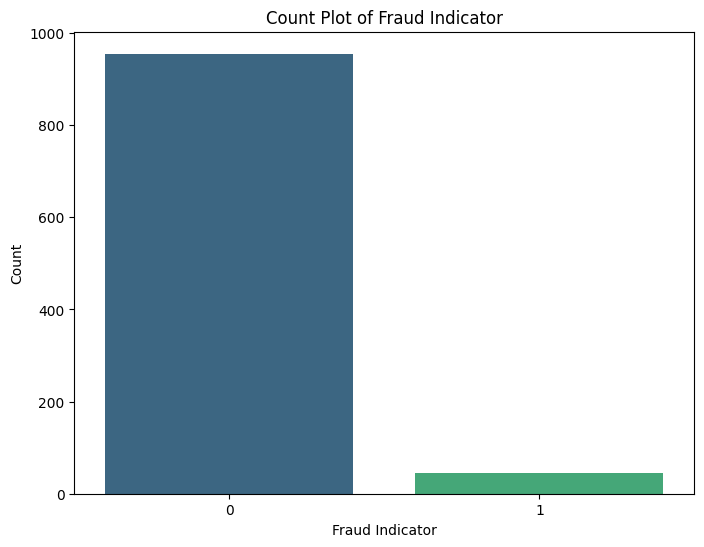

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with a 'FraudIndicator' column
# Load your data into the DataFrame if not already done

# Create a count plot for the 'FraudIndicator' column
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.countplot(data=data_df1, x='FraudIndicator', palette='viridis')
plt.title('Count Plot of Fraud Indicator')
plt.xlabel('Fraud Indicator')
plt.ylabel('Count')
plt.show()


### Logistic regression using sampled Data

Class distribution after oversampling: Counter({0: 955, 1: 955})


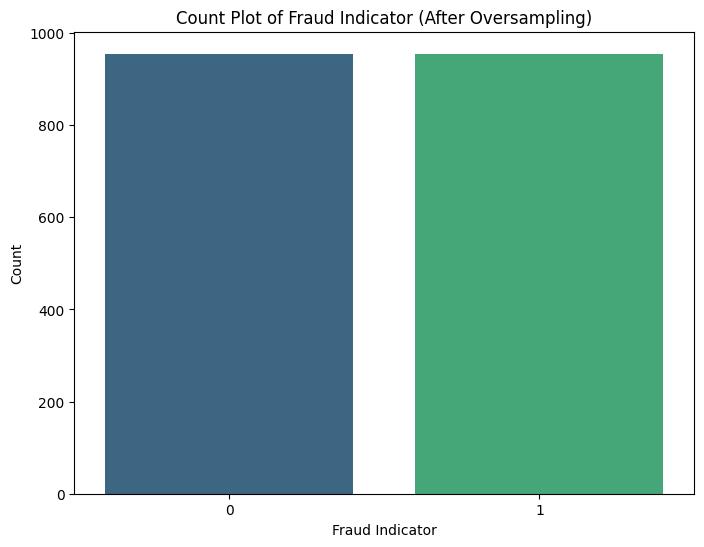

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

# Initialize SMOTE for oversampling
smote = SMOTE(random_state=42)

# Apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X, Y)

# Check the class distribution after oversampling
print("Class distribution after oversampling:", Counter(y_resampled))

# Create a count plot for the 'FraudIndicator' column after oversampling
plt.figure(figsize=(8, 6))
sns.countplot(data=pd.DataFrame({'FraudIndicator': y_resampled}), x='FraudIndicator', palette='viridis')
plt.title('Count Plot of Fraud Indicator (After Oversampling)')
plt.xlabel('Fraud Indicator')
plt.ylabel('Count')
plt.show()


In [48]:
# Retraining Logistic regression using SAMPLED Data
model = LogisticRegression()

# Train the model on the training data
model.fit(X_resampled, y_resampled)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate and print various metrics to evaluate the model's performance
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
confusion = confusion_matrix(Y_test, y_pred)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion)

Model Evaluation Metrics:
Accuracy: 0.555
Precision: 0.06818181818181818
Recall: 0.46153846153846156
F1 Score: 0.1188118811881188
Confusion Matrix:
[[105  82]
 [  7   6]]


In [ ]:
# Logistic Regression model with Sample Data with Mlflow

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Iniciar un nuevo run en MLflow
with mlflow.start_run():
    model = LogisticRegression()

    # Train the model on the training data
    model.fit(X_resampled, y_resampled)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Calculate and print various metrics to evaluate the model's performance
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average="weighted")
    recall = recall_score(Y_test, y_pred, average="weighted")
    f1 = f1_score(Y_test, y_pred, average="weighted")
    confusion = confusion_matrix(Y_test, y_pred)

    # Registrar métricas
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("confusion", confusion)

    # Capturar firma del modelo
    signature = infer_signature(X_train, model.predict(X_train))

    # Registrar el modelo
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="logistic_regression_model_withSampleData",
        signature=signature,
        registered_model_name="logistic-regression-withSampleData-experiment"
    )

    print(f"Run ID: {mlflow.active_run().info.run_id}")  # Identificador único de este experimento

### Logistic Regression Model with Hyperparameter Tuning

Encontrar los valores óptimos de los hiperparámetros de un modelo de aprendizaje automático para mejorar su rendimiento.

In [49]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the logistic regression model
model = LogisticRegression()

# Define a range of hyperparameters to search
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization type
    'C': np.logspace(-3, 3, 7),  # Inverse of regularization strength (smaller values for stronger regularization)
    'solver': ['liblinear'],  # Solver for l1 regularization
}

# Create a grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the resampled data
y_pred = best_model.predict(X_resampled)

# Calculate and print various metrics to evaluate the model's performance on the resampled data
accuracy = accuracy_score(y_resampled, y_pred)
precision = precision_score(y_resampled, y_pred)
recall = recall_score(y_resampled, y_pred)
f1 = f1_score(y_resampled, y_pred)
confusion = confusion_matrix(y_resampled, y_pred)

print("Model Evaluation Metrics on Resampled Data:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion)


Best Hyperparameters: {'C': np.float64(1000.0), 'penalty': 'l1', 'solver': 'liblinear'}
Model Evaluation Metrics on Resampled Data:
Accuracy: 0.6162303664921466
Precision: 0.611
Recall: 0.6397905759162303
F1 Score: 0.6250639386189258
Confusion Matrix:
[[566 389]
 [344 611]]


In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def evaluate_classification_models(X_resampled, y_resampled):
    # Split the resampled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    # Define a dictionary of classification models
    models = {
        "Decision Tree Classifier": DecisionTreeClassifier(),
        "Random Forest Classifier": RandomForestClassifier(),
        "Support Vector Machine (SVM)": SVC(),
        "K-Nearest Neighbors (KNN)": KNeighborsClassifier(),
        "Gradient Boosting Classifier": GradientBoostingClassifier()
    }
    
    results = {}
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate and store various metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        confusion = confusion_matrix(y_test, y_pred)
        
        results[model_name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Confusion Matrix": confusion
        }
    
    return results

results = evaluate_classification_models(X_resampled, y_resampled)
for model_name, model_result in results.items():
     print(f"Results for {model_name}:")
     for metric, value in model_result.items():
         print(f"{metric}: {value}")
     print()


Results for Decision Tree Classifier:
Accuracy: 0.837696335078534
Precision: 0.8232323232323232
Recall: 0.8578947368421053
F1 Score: 0.8402061855670103
Confusion Matrix: [[157  35]
 [ 27 163]]

Results for Random Forest Classifier:
Accuracy: 0.9267015706806283
Precision: 0.905
Recall: 0.9526315789473684
F1 Score: 0.9282051282051282
Confusion Matrix: [[173  19]
 [  9 181]]

Results for Support Vector Machine (SVM):
Accuracy: 0.6073298429319371
Precision: 0.6333333333333333
Recall: 0.5
F1 Score: 0.5588235294117647
Confusion Matrix: [[137  55]
 [ 95  95]]

Results for K-Nearest Neighbors (KNN):
Accuracy: 0.819371727748691
Precision: 0.759656652360515
Recall: 0.9315789473684211
F1 Score: 0.8368794326241135
Confusion Matrix: [[136  56]
 [ 13 177]]

Results for Gradient Boosting Classifier:
Accuracy: 0.8403141361256544
Precision: 0.7972350230414746
Recall: 0.9105263157894737
F1 Score: 0.8501228501228502
Confusion Matrix: [[148  44]
 [ 17 173]]



# Ranking Models perfromance
1. Random Forest Classifier
2. Gradient Boosting Algorithm
3. Decision Tree Classifier
4. K-Nearest Neighbours
5. Support Vector Machine (SVC)
6. Logistic Regression

### Now we can HyperParameterTune the <h1><b>RandomForest CLassifier</b></h1>

In [51]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# Define a range of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Create a grid search with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the grid search to the resampled data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Train the best model on the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = best_rf_model.predict(X_test)

# Calculate and print various metrics to evaluate the best model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

print("Best Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion)


Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Model Evaluation Metrics:
Accuracy: 0.9293193717277487
Precision: 0.9014778325123153
Recall: 0.9631578947368421
F1 Score: 0.9312977099236641
Confusion Matrix:
[[172  20]
 [  7 183]]
